# HW4
## Question 1 Exploratory Data Analysis


From example/input/ load compustat.csv inside compustat.zip without unzip compustat.zip

In [22]:
import pandas as pd
from zipfile import ZipFile

In [23]:
myzip=ZipFile('compustat.zip')
f=myzip.open('compustat.csv')
df=pd.read_csv(f)

### Variable names that we are interested in:

sic code: four digits integer for company
datecqtr: year/ quarter time for the record
cusip: compustats identifier for a company
chod: shares out of standing (in million)
saleq: sales of current quarter (in million)
prccq: close price of current quarter (in dollar)

In [24]:
df = df.loc[:,['sic','datacqtr','cusip','cshoq','saleq','prccq']]

### For saleq and market cap, compute the following:

Time series mean;
Time Series standard deviation;
Time Series count of missing values;
Time Series ratio of missing values;
Aggregate the result in a dataframe;

In [25]:
#compute market cap
df['mktcap'] = df['cshoq'] * df['prccq'] 

In [26]:
#Time series mean
df['saleq'].mean()

445.1506638794169

In [27]:
#Time Series standard deviation
df['saleq'].std()

2679.706576405277

In [28]:
#Time Series count of missing values
df['saleq'].isnull().sum()

269498

In [29]:
#Time Series ratio of missing values
df['saleq'].isnull().sum()/len(df)

0.14878714116222666

In [13]:
#Aggregate the result in a dataframe
result = pd.DataFrame()
result['mean'] = [df['saleq'].mean()]
result['std'] = [df['saleq'].std()]
result['count_miss'] = df['saleq'].isnull().sum()
result['ratio_miss'] = df['saleq'].isnull().sum()/len(df)
print(result)

         mean          std  count_miss  ratio_miss
0  445.150664  2679.706576      269498    0.148787


### Answer the following questions:

Before computing any value, what kinds of descriptive analysis would you do to check if there are outliers?

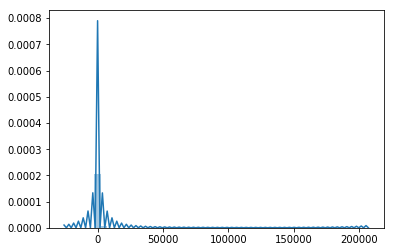

In [15]:
#Distriubtion-Plot
sns.distplot(df['saleq'].dropna().values)

In [27]:
#use IQR score to deal with outliers
#25% quantile
Q1 = df['saleq'].quantile(0.25)
#75% quantile
Q3 = df['saleq'].quantile(0.75)
#IQR
IQR = Q3 - Q1
#create a new saleq column that got rid of outliers
df['saleq_new'] = df['saleq'][(df['saleq'] > (Q1 - 1.5 * IQR)) & (df['saleq'] < (Q3 + 1.5 * IQR))]
#compute the mean\std\missing value of the new column
result_new = pd.DataFrame()
result_new['mean'] = [df['saleq_new'].mean()]
result_new['std'] = [df['saleq_new'].std()]
result_new['count_miss'] = df['saleq_new'].isnull().sum()
result_new['ratio_miss'] = df['saleq_new'].isnull().sum()/len(df)
print(result_new)

        mean        std  count_miss  ratio_miss
0  44.668567  68.204818      504108    0.278313


## Question 2 Compute Industry Concentration

The defination of HHI index could be found:
https://www.investopedia.com/terms/h/hhi.asp#:~:text=The%20Herfindahl%2DHirschman%20Index%20(HHI)%20is%20a%20commonly%20accepted,close%20to%20zero%20to%2010%2C000.
This index is used to measure the industry concentration and was used by congressman to determine whether to approve a merge deal or not.
Using the same data in question 1. Compute a panel data for HHI index for all industry, using a 2 digit SIC code.
Choose top 4 industry with the highest average HHI index, plot their time series pattern of HHI in a 2 by 2 figure.

In [84]:
#transform SIC to a 2 digit code
df.dropna(inplace=True)
df['sic_2digit'] = (df['sic']//100).astype('int')

In [85]:
#use pivot table to compute the saleq_sum(quarterly sum of sales in a certain industry) of a industry in a quarter
saleq_sum = pd.pivot_table(df, index=['sic_2digit','datacqtr'],values=['saleq'],aggfunc='sum')
#set the index to ['sic_2digit','datacqtr']
df_new = df.set_index(['sic_2digit','datacqtr'])
df_new['saleq_sum'] = saleq_sum

In [86]:
#compute the percentage of share of a company in a quarter
df_new['share'] = df_new['saleq']*100/df_new['saleq_sum']
#compute the square of share
df_new['share_square'] = df_new['share']**2

In [108]:
#compute the HHI of each industry in each quarter
HHI = pd.pivot_table(df_new,index=['sic_2digit','datacqtr'],values=['share_square'],aggfunc='sum')
HHI.columns = ['HHI']
#remove the items where HHI == 10000 
HHI = HHI[HHI['HHI']<9999]
print(HHI.head())

                             HHI
sic_2digit datacqtr             
1          1968Q4    5400.087472
           1969Q3    5104.971184
           1969Q4    5499.740746
           1970Q1    4060.728397
           1970Q2    5718.446132


In [109]:
#compute average HHI of each industry
avg_HHI = pd.pivot_table(HHI,index=['sic_2digit'],values=['HHI'])
#sort
avg_HHI = avg_HHI.sort_values(ascending=False,by='HHI')
print(avg_HHI.head(4))

                    HHI
sic_2digit             
84          8966.251168
81          8940.775614
9           7439.484810
2           7351.215863


In [139]:
#the four industries selected
ind = avg_HHI.index.values[0:4]
print(ind)
HHI_top4 = HHI.loc[ind]
HHI_top4.reset_index(inplace=True)

[84 81  9  2]


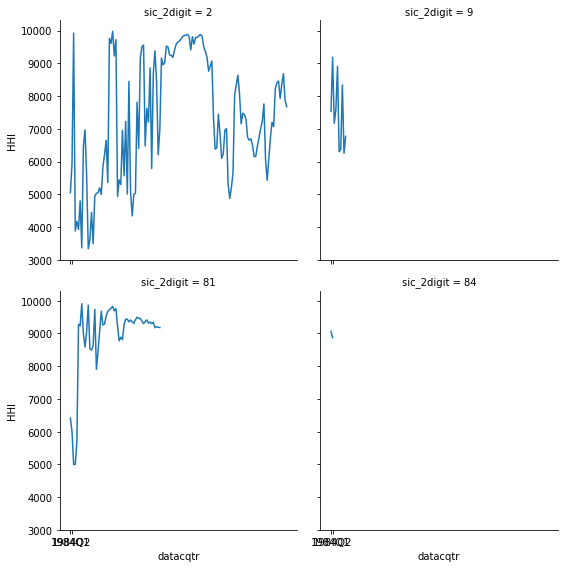

In [140]:
g = sns.FacetGrid(HHI_top4, col = 'sic_2digit', col_wrap =2, height=4) 
g.map(plt.plot,'datacqtr','HHI')